In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
#load csv
pga_df = pd.read_csv('pga_rawdata.csv')

pga_df.head()

,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,...,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,...,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,...,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,...,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,...,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,...,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


In [3]:
#data cleaning

#drop unneeded columns
kept_columns = ['player', 'tournament name', 'season', 'pos', 'hole_par', 'strokes', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
dropped_columns = [col for col in pga_df.columns if col not in kept_columns]
filtered_df = pga_df.drop(columns=dropped_columns)

#removes players who missed the cut
df_cuts = filtered_df[filtered_df['hole_par'] > 160]

#removes rows that don't have strokes gained data
df_no_sg = df_cuts.dropna(subset=['sg_total'])

#filters data to courses that have a par of 72 (or 288 over 4 golf rounds)
df_par = df_no_sg[df_no_sg['hole_par'] == 288]

#removes last of rows with null values
df = df_par.dropna()

#adds score column
df.loc[:, 'score'] = df['strokes'] - df['hole_par']

#final dataframe
df

/var/folders/js/v9gqwrcj5nsg_r2cclzp51lw0000gn/T/ipykernel_80987/2242143000.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'score'] = df['strokes'] - df['hole_par']


,hole_par,strokes,pos,player,tournament name,season,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,score
0,288,289,32.0,Abraham Ancer,The Memorial Tournament pres. by Nationwide,2022,0.20,-0.13,-0.08,0.86,0.65,0.85,1
1,288,286,18.0,Adam Hadwin,The Memorial Tournament pres. by Nationwide,2022,0.36,0.75,0.31,0.18,1.24,1.60,-2
6,288,287,26.0,Aaron Rai,The Memorial Tournament pres. by Nationwide,2022,2.05,0.74,-1.32,-0.12,-0.70,1.35,-1
7,288,287,26.0,Adam Schenk,The Memorial Tournament pres. by Nationwide,2022,-0.96,-0.01,1.84,0.48,2.31,1.35,-1
8,288,299,67.0,Adam Scott,The Memorial Tournament pres. by Nationwide,2022,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36457,288,288,61.0,Sean O'Hair,Sanderson Farms Championship,2015,-0.84,0.62,0.15,-0.47,0.30,-0.54,0
36461,288,282,25.0,Shawn Stefani,Sanderson Farms Championship,2015,0.09,-0.56,0.62,0.81,0.87,0.96,-6
36466,288,284,35.0,Tom Hoge,Sanderson Farms Championship,2015,0.03,0.33,0.37,-0.27,0.43,0.46,-4
36471,288,280,20.0,Vaughn Taylor,Sanderson Farms Championship,2015,1.95,-0.23,0.96,-1.23,-0.50,1.46,-8


In [4]:
#check for null values
df.isna().any()

hole_par           False
strokes            False
pos                False
player             False
tournament name    False
season             False
sg_putt            False
sg_arg             False
sg_app             False
sg_ott             False
sg_t2g             False
sg_total           False
score              False
dtype: bool

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5745 entries, 0 to 36473
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hole_par         5745 non-null   int64  
 1   strokes          5745 non-null   int64  
 2   pos              5745 non-null   float64
 3   player           5745 non-null   object 
 4   tournament name  5745 non-null   object 
 5   season           5745 non-null   int64  
 6   sg_putt          5745 non-null   float64
 7   sg_arg           5745 non-null   float64
 8   sg_app           5745 non-null   float64
 9   sg_ott           5745 non-null   float64
 10  sg_t2g           5745 non-null   float64
 11  sg_total         5745 non-null   float64
 12  score            5745 non-null   int64  
dtypes: float64(7), int64(4), object(2)
memory usage: 628.4+ KB


In [7]:
#aggregating data so that each row contain's each player's average stats
numeric_columns = df.select_dtypes(include=[np.number]).columns

#group by 'player' column and aggregate numeric columns by mean
df_aggregated = df.groupby('player')[numeric_columns].mean().reset_index()

#filters non numeric columns out
non_numeric_columns = ['player', 'tournament name']
for column in non_numeric_columns:
    df_aggregated[column] = df.groupby('player')[column].first().reset_index(drop=True)

df_aggregated = df_aggregated[['player', 'tournament name'] + list(numeric_columns)]

df_aggregated


             player                              tournament name  hole_par  \
0    Aaron Baddeley                            Valero Texas Open     288.0   
1         Aaron Rai  The Memorial Tournament pres. by Nationwide     288.0   
2        Aaron Wise  The Memorial Tournament pres. by Nationwide     288.0   
3     Abraham Ancer  The Memorial Tournament pres. by Nationwide     288.0   
4       Adam Hadwin  The Memorial Tournament pres. by Nationwide     288.0   
..              ...                                          ...       ...   
387      Yuta Ikeda                     The Players Championship     288.0   
388       Zac Blair                      Rocket Mortgage Classic     288.0   
389    Zach Johnson                            Valero Texas Open     288.0   
390     Zack Sucher                        Barbasol Championship     288.0   
391     Zecheng Dou                            Valero Texas Open     288.0   

        strokes        pos       season   sg_putt        sg_arg

In [9]:
#extract 'strokes gained' stats for each golfer and scale them
scaler = StandardScaler()
numerical_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

df[numerical_features] = scaler.fit_transform(df[numerical_features])

/var/folders/js/v9gqwrcj5nsg_r2cclzp51lw0000gn/T/ipykernel_80987/1402698220.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [10]:
# Calculates cosine similarity based on golfers' strokes gained
def find_similarities(golfer, df):
    golfer_row = df[df['player'] == golfer].index[0]
    golfer_features = df.iloc[golfer_row][numerical_features].values.reshape(1, -1)
    similarities = cosine_similarity(golfer_features, df[numerical_features])
    
    return similarities

In [11]:
#finds most similar golfers
def most_similar_golfers(similarity_scores, df, top_n=10):
    similar_golfers_indices = similarity_scores.argsort()[0][::-1][1:top_n+1]
    similar_golfers = df.iloc[similar_golfers_indices]
    
    return similar_golfers

In [13]:
# Define the number of clusters
num_clusters = 3  # You can adjust this number based on your preference

# Extract features for clustering (you can choose which features to include)
features_for_clustering = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']

# Prepare data for clustering
X = df_aggregated[features_for_clustering]

# Initialize KMeans object
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans clustering model to the data
kmeans.fit(X)

# Add cluster labels to DataFrame
df_aggregated['cluster'] = kmeans.labels_

# Print the cluster centers
print("Cluster Centers:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=features_for_clustering))

# Print the count of golfers in each cluster
print("\nCount of golfers in each cluster:")
print(df_aggregated['cluster'].value_counts())

# Optionally, you can visualize the clusters using PCA or other dimensionality reduction techniques


Cluster Centers:
    sg_putt    sg_arg    sg_app    sg_ott    sg_t2g  sg_total
0  0.149197  0.169008  0.493721  0.258392  0.921428  1.078710
1  0.264007  0.061604  0.098742 -0.009520  0.150934  0.424250
2  0.226939 -0.186345 -0.600495 -0.396502 -1.183191 -0.954653

Count of golfers in each cluster:
cluster
1    195
0    156
2     41
Name: count, dtype: int64


In [14]:

# Define composite features representing player profiles
df_aggregated['Driving_Putting_Strength'] = df_aggregated['sg_ott'] + df_aggregated['sg_putt']
df_aggregated['Approach_T2G_Strength'] = df_aggregated['sg_app'] + df_aggregated['sg_t2g']
df_aggregated['Short_Game_Strength'] = df_aggregated['sg_arg'] + df_aggregated['sg_putt']  # You can adjust this based on preference

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_aggregated[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
                                                     'Driving_Putting_Strength', 'Approach_T2G_Strength',
                                                     'Short_Game_Strength']])

# Apply K-means clustering
num_clusters = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(normalized_data)
df_aggregated['cluster'] = kmeans.labels_

# Interpret clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert cluster centers back to original scale


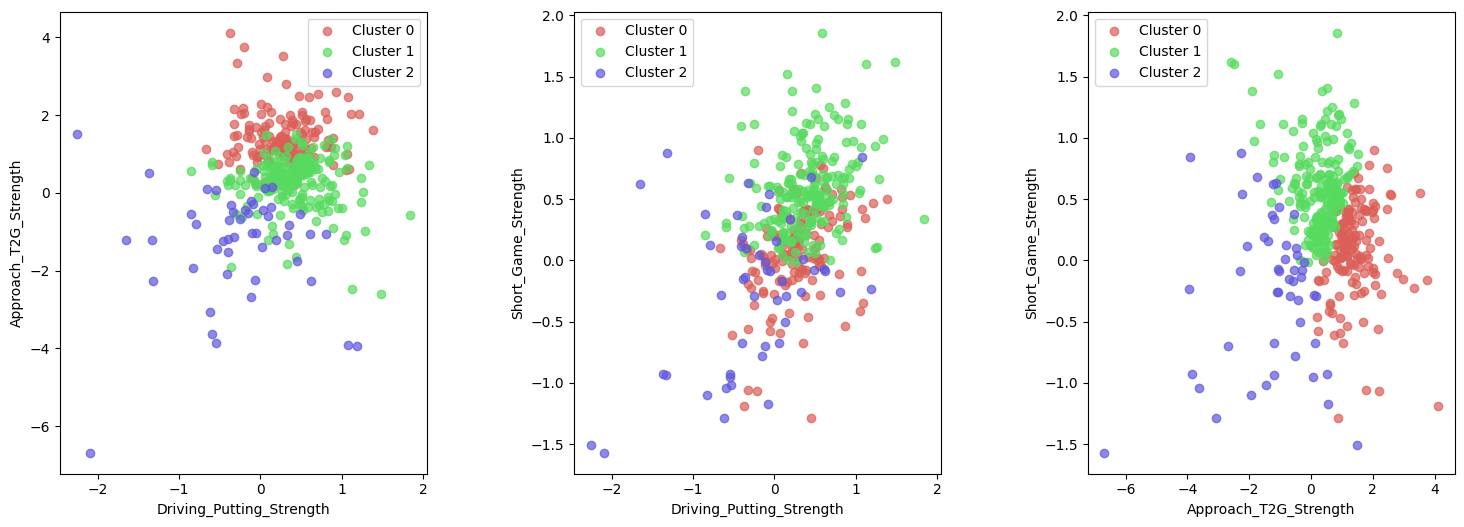

In [16]:
# Set up the grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Define feature pairs
feature_pairs = [('Driving_Putting_Strength', 'Approach_T2G_Strength'),
                 ('Driving_Putting_Strength', 'Short_Game_Strength'),
                 ('Approach_T2G_Strength', 'Short_Game_Strength')]

# Plot each pair of features
for i, (feature1, feature2) in enumerate(feature_pairs):
    ax = axes[i]

    # Plot each cluster
    for cluster_label, color in zip(range(num_clusters), sns.color_palette('hls', num_clusters)):
        cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
        ax.scatter(cluster_data[feature1], cluster_data[feature2], label=f'Cluster {cluster_label}', color=color, alpha=0.7)

    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.legend()

plt.show()


In [17]:
# Print the count of players in each cluster
print("Count of players in each cluster:")
print(df_aggregated['cluster'].value_counts())

# Print the list of players in each cluster
for cluster_label in range(num_clusters):
    print(f"\nPlayers in Cluster {cluster_label}:")
    players_in_cluster = df_aggregated[df_aggregated['cluster'] == cluster_label]['player']
    print(players_in_cluster)


Count of players in each cluster:
cluster
1    196
0    147
2     49
Name: count, dtype: int64

Players in Cluster 0:
2             Aaron Wise
3          Abraham Ancer
7             Adam Scott
8          Adam Svensson
11            Alex Prugh
             ...        
380       Will Zalatoris
381       William McGirt
383    Xander Schauffele
385            Y.E. Yang
387           Yuta Ikeda
Name: player, Length: 147, dtype: object

Players in Cluster 1:
0      Aaron Baddeley
1           Aaron Rai
4         Adam Hadwin
5           Adam Long
6         Adam Schenk
            ...      
382     Wyndham Clark
384      Xinjun Zhang
388         Zac Blair
389      Zach Johnson
391       Zecheng Dou
Name: player, Length: 196, dtype: object

Players in Cluster 2:
18             Andrew Loupe
24              Arjun Atwal
39             Brad Kennedy
40               Brad Marek
45            Brandon Stone
76        Chandler Phillips
86              Chris Baker
90           Chris Thompson
96           

In [20]:
# Function to find most similar players within each cluster
def most_similar_players_in_cluster(cluster_label, similarity_metric='cosine', top_n=5):
    cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
    cluster_features = cluster_data[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']]
    
    # Compute similarity scores within the cluster
    if similarity_metric == 'cosine':
        similarity_scores = cosine_similarity(cluster_features, cluster_features)
    # You can add other similarity metrics here if needed
    
    # Find most similar players for each player in the cluster
    most_similar_players = {}
    for i, player_row in enumerate(cluster_data.itertuples()):
        player = player_row.player
        similarities = similarity_scores[i]
        similar_players_indices = similarities.argsort()[-(top_n+1):-1][::-1]  # Exclude the player itself
        similar_players = cluster_data.iloc[similar_players_indices]['player'].tolist()
        most_similar_players[player] = similar_players
    
    return most_similar_players

# Print most similar players in each cluster
for cluster_label in range(num_clusters):
    print(f"\nMost similar players in Cluster {cluster_label}:")
    similar_players = most_similar_players_in_cluster(cluster_label)
    for player, similar_players_list in similar_players.items():
        print(f"{player}: {similar_players_list}")




Most similar players in Cluster 0:
Aaron Wise: ['Lucas Glover', 'Harold Varner III', 'Keegan Bradley', 'Scottie Scheffler', 'Will Zalatoris']
Abraham Ancer: ['Charley Hoffman', 'Jason Kokrak', 'Ryan Palmer', 'Bryson DeChambeau', 'Dustin Johnson']
Adam Scott: ['Paul Casey', 'Henrik Stenson', 'Gary Woodland', 'William McGirt', 'Bo Hoag']
Adam Svensson: ['Brandon Harkins', 'Chad Campbell', 'Roberto Castro', 'Doug Ghim', 'Davis Riley']
Alex Prugh: ['Bryson DeChambeau', 'Abraham Ancer', 'Jon Rahm', 'Charley Hoffman', 'Jason Kokrak']
Alex Smalley: ['Byeong Hun An', 'Sam Horsfield', 'Vijay Singh', 'Mito Pereira', 'Kevin Chappell']
Anders Albertson: ['Yuta Ikeda', 'Matthew NeSmith', 'Roberto Castro', 'Cameron Percy', 'Collin Morikawa']
Andres Gonzales: ['Phil Mickelson', 'Tom Hoge', 'Jim Furyk', 'George McNeill', 'Nate Lashley']
Andrew Landry: ['Graham DeLaet', 'Jim Herman', 'Max Homa', 'James Hahn', 'Cameron Davis']
Antoine Rozner: ['Matthew NeSmith', 'Hao-Tong Li', 'Joseph Bramlett', 'Yuta 

In [23]:
# Function to find most similar players within each cluster and summarize the data
def summarize_similar_players(cluster_label, similarity_metric='cosine', top_n=3):
    cluster_data = df_aggregated[df_aggregated['cluster'] == cluster_label]
    cluster_features = cluster_data[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']]
    
    # Compute similarity scores within the cluster
    if similarity_metric == 'cosine':
        similarity_scores = cosine_similarity(cluster_features, cluster_features)
    # You can add other similarity metrics here if needed
    
    # Find most similar players for each player in the cluster
    summarized_data = {}
    for i, player_row in enumerate(cluster_data.itertuples()):
        player = player_row.player
        similarities = similarity_scores[i]
        similar_players_indices = similarities.argsort()[-(top_n+1):-1][::-1]  # Exclude the player itself
        similar_players = cluster_data.iloc[similar_players_indices][['player', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']]
        summarized_data[player] = similar_players
    
    return summarized_data

# Print summarized data for each cluster
for cluster_label in range(num_clusters):
    print(f"\nMost similar players and summary for Cluster {cluster_label}:")
    summarized_data = summarize_similar_players(cluster_label)
    for player, similar_players_data in summarized_data.items():
        print(f"\nPlayer: {player}")
        print("Most similar players:")
        print(similar_players_data)



Most similar players and summary for Cluster 0:

Player: Aaron Wise
Most similar players:
                player   sg_putt    sg_arg    sg_app    sg_ott    sg_t2g  \
221       Lucas Glover -0.065714  0.102143  0.371190  0.313571  0.787857   
141  Harold Varner III -0.033235  0.127647  0.395294  0.375882  0.899118   
198     Keegan Bradley -0.134186  0.235814  0.645116  0.375814  1.257907   

     sg_total  
221  0.746190  
141  0.893235  
198  1.123256  

Player: Abraham Ancer
Most similar players:
              player   sg_putt    sg_arg    sg_app    sg_ott  sg_t2g  sg_total
79   Charley Hoffman  0.374167 -0.015833  0.384167  0.429444  0.8000  1.174167
161     Jason Kokrak  0.403750  0.012000  0.381250  0.428500  0.8205  1.223500
303      Ryan Palmer  0.374400 -0.081600  0.486000  0.517600  0.9228  1.297200

Player: Adam Scott
Most similar players:
             player   sg_putt    sg_arg    sg_app    sg_ott    sg_t2g  \
270      Paul Casey  0.248261  0.145217  0.793478  0.260870  1.1